In [1]:
#importando os pacotes que serão utilizados
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
#abrindo o arquivo 
previsão = xr.open_dataset('forecast.nc')
#vendo o que tem e como está dividido o arquivo
previsão

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 37, time: 72)
Coordinates:
  * lat      (lat) float32 -25.294006 -25.07425 ... -20.144089 -19.915924
  * lon      (lon) float32 -52.9937 -52.750793 ... -44.492203 -44.2493
  * time     (time) datetime64[ns] 2018-04-14 ... 2018-04-16T23:00:00
Data variables:
    t2m      (time, lat, lon) float32 ...

In [3]:
#abrindo o arquivo
observados = xr.open_dataset('observation.nc')
#vendo o que tem e como está dividido o arquivo
observados

<xarray.Dataset>
Dimensions:      (lat: 25, lon: 37, time: 72)
Coordinates:
  * time         (time) datetime64[ns] 2018-04-14 ... 2018-04-16T23:00:00
  * lon          (lon) float32 -52.9937 -52.7508 -52.5079 ... -44.4922 -44.2493
  * lat          (lat) float32 -25.29401 -25.07425 ... -20.14409 -19.91592
Data variables:
    temperatura  (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.1 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Thu Apr 19 18:43:01 2018: cdo remapbil,gridfile observation...
    CDO:          Climate Data Operators version 1.9.1 (http://mpimet.mpg.de/...

In [4]:
#extraindo as variaveis    
temp_p = previsão['t2m'] - 273.15  #passei para celsius
temp_o = observados['temperatura']
#igualando as lat e lon
temp_p.coords['lat'] = temp_o.lat
temp_p.coords['lon'] = temp_o.lon

In [5]:
#usando a função do pandas pd.date_range ela retorna uma frequencia fixa, aqui indicando quando a data inicia e termina, e nosso intervalo de 6 horas
t = pd.date_range(start='2018-04-14T00:00:00.000000000', end='2018-04-16T23:00:00.000000000', freq='6H')
#criamos uma lista vazia
lista = []
for tempo in t:
    prev=temp_p.sel(time=slice(tempo, tempo+pd.Timedelta('6H')))  
    obs=temp_o.sel(time=slice(tempo, tempo+pd.Timedelta('6H')))
    dif = (prev - obs)**2 
    rmse = (dif.mean(dim='time')**0.5).assign_coords(time=tempo) #cálculo do rmse
    lista.append(rmse)
final = xr.concat(lista, dim='time')
final

<xarray.DataArray (time: 12, lat: 25, lon: 37)>
array([[[1.787825  , 3.0440204 , 4.719558  , ..., 2.064227  ,
         2.0780709 ,        nan],
        [2.4105785 , 3.1245978 , 3.9519787 , ..., 2.3713818 ,
         2.1269946 ,        nan],
        [2.1613638 , 2.2433496 , 3.1746347 , ..., 2.6637304 ,
         2.3710728 , 2.0758886 ],
        ...,
        [4.0251265 , 4.1910524 , 3.644818  , ..., 2.5965025 ,
         2.8346386 , 2.187299  ],
        [3.8557584 , 4.006676  , 3.529442  , ..., 2.896549  ,
         3.5179086 , 2.2452996 ],
        [4.026857  , 3.1649072 , 3.2282217 , ..., 3.232596  ,
         3.8431468 , 2.449333  ]],

       [[1.9933242 , 2.500987  , 3.1586208 , ..., 2.4181643 ,
         2.4750383 ,        nan],
        [2.4860032 , 2.833765  , 2.9004383 , ..., 2.4667444 ,
         2.5011606 ,        nan],
        [2.3552735 , 2.3645544 , 2.8001223 , ..., 2.5289392 ,
         2.6090298 , 2.6467192 ],
...
        [0.64967084, 0.7747221 , 0.4922489 , ..., 1.554249  ,
         1.4215162 , 0.54552895],
        [0.8320585 , 1.5512755 , 0.79071224, ..., 1.6455914 ,
         1.4182752 , 1.3441942 ],
        [1.8848724 , 1.3403674 , 1.2604544 , ..., 1.83201   ,
         2.1763465 , 2.1284425 ]],

       [[0.6915859 , 0.69973785, 1.0062234 , ..., 0.92779815,
         0.9920345 ,        nan],
        [1.6527056 , 1.4966779 , 1.4472405 , ..., 1.243626  ,
         1.0948561 ,        nan],
        [1.4001062 , 1.0755979 , 1.4981184 , ..., 1.4753113 ,
         1.2974955 , 1.1309389 ],
        ...,
        [0.6805753 , 0.7512725 , 1.1632147 , ..., 0.8450887 ,
         0.9520795 , 0.6310589 ],
        [0.46408063, 0.86970127, 0.48629135, ..., 1.0908952 ,
         0.99642026, 1.0990871 ],
        [1.0790554 , 0.96524054, 0.7856203 , ..., 1.3237468 ,
         1.5418301 , 1.7325102 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -25.29401 -25.07425 -24.85408 ... -20.14409 -19.91592
  * lon      (lon) float32 -52.9937 -52.7508 -52.5079 ... -44.4922 -44.2493
  * time     (time) datetime64[ns] 2018-04-14 ... 2018-04-16T18:00:00

In [6]:
##passar os valores para um dado .nc
final.to_netcdf('valores_rsme.nc')

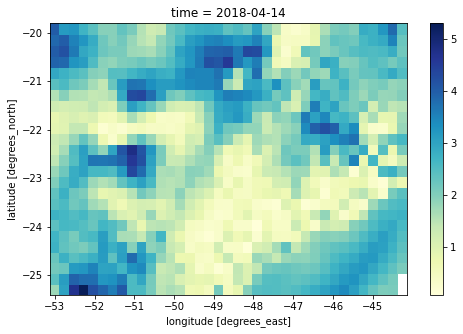

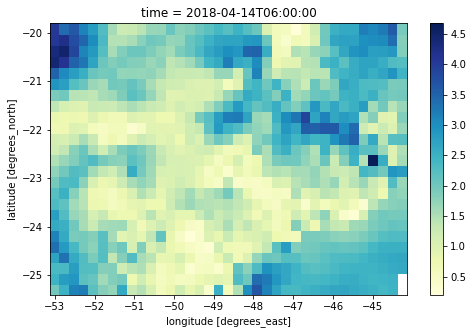

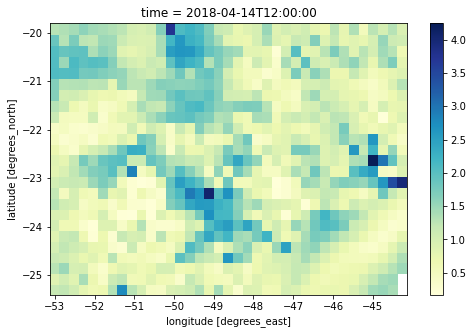

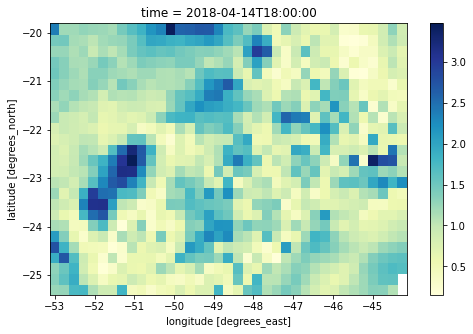

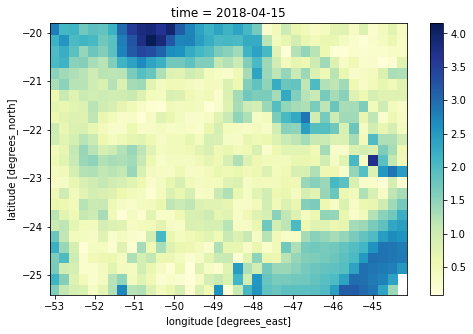

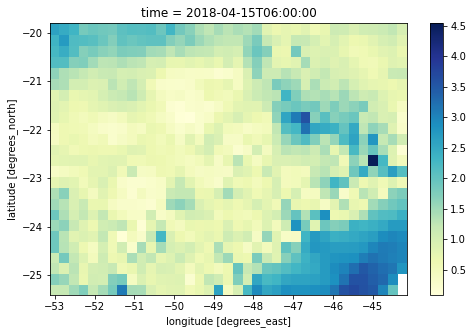

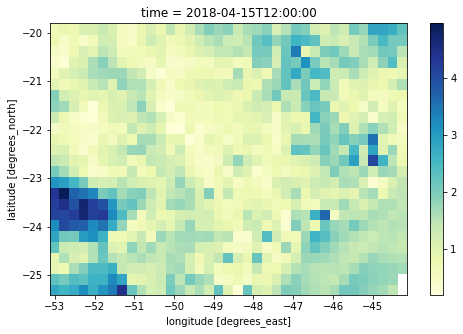

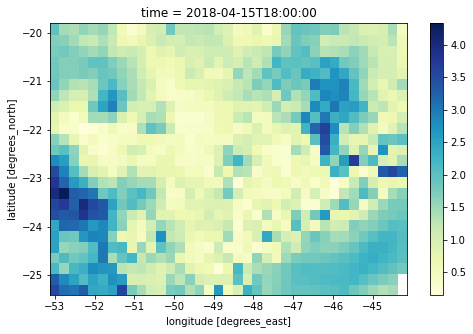

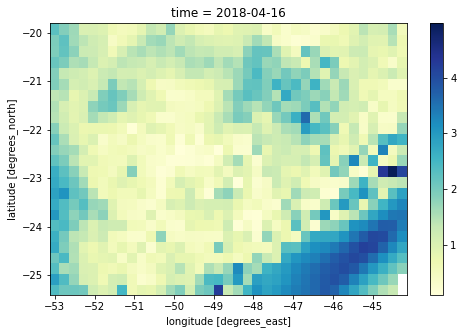

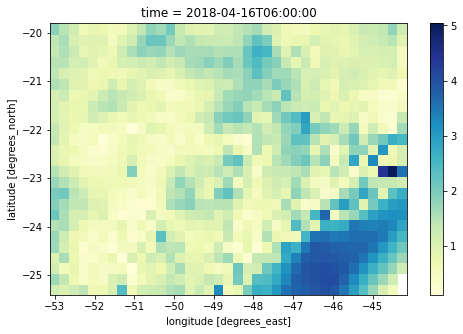

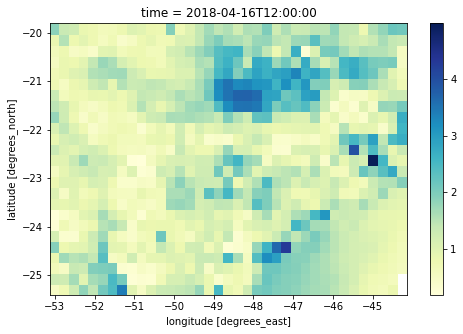

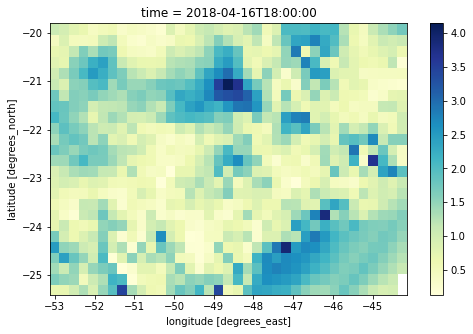

In [7]:
#####Plotar mapas de duas dimensões do índice de cada período 
for x in final.coords['time']:
    fig = plt.figure(figsize=(8,5))
    final.sel(time=x).plot(cmap='YlGnBu')
    plt.show()

Text(0.5, 1.0, 'Índice RMSE: São Paulo')

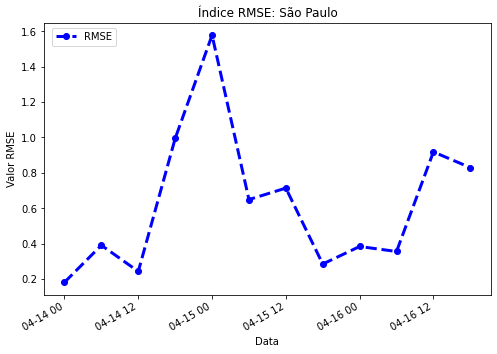

In [8]:
#gráfico da série temporal do mesmo índice para São Paulo
fig,ax  = plt.subplots(figsize=(8,5))
final.sel(lon=-46.6388, lat=-23.5489, method='nearest').plot(color = 'blue', marker = 'o', lw =3, ls = '--', label = 'RMSE')
ax.set_xlabel('Data')
ax.set_ylabel('Valor RMSE')
fig.legend(loc=2, bbox_to_anchor=(.13,.88))
plt.title('Índice RMSE: São Paulo')